# Vision Transformer from scratch: training end to end

This notebook implements the Vision Transformer architecture described in the ViT paper "AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE" and trains it end to end.

ViT converts an image into a sequence of patch tokens, then applies a standard Transformer encoder.
If an image is split into $N$ patches and each token has dimension $D$, the token sequence has shape $[B, N+1, D]$ because we also prepend a learnable class token $[\mathrm{CLS}]$.


<img src="assets/vit_architecture.png" alt="VIT Architecture" width="900" height="600">


## Imports and device

We import PyTorch, torchvision for data, and matplotlib for visualization.
We also choose a compute device. Training a ViT-Base model can be slow on CPU, so a GPU helps.


In [1]:
import math
from typing import Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


## Dataset and preprocessing (small subset)

The ViT-Base/16 model in the paper is typically trained on $224 \times 224$ images with patch size $P=16$.
That produces $(224/16)^2 = 14^2 = 196$ patch tokens, and with the class token the sequence length is $197$.

To match the ViT-Base/16 tokenization, we resize CIFAR-10 images from $32 \times 32$ to $224 \times 224$.


In [2]:
# CIFAR-10 normalization stats
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

img_size = 224
patch_size = 16

train_tfms = T.Compose([
    T.Resize(img_size),
    T.RandomCrop(img_size, padding=8),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(cifar10_mean, cifar10_std),
])

test_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(cifar10_mean, cifar10_std),
])

full_train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
full_test_ds  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

classes = full_train_ds.classes
print("Classes:", classes)

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


To keep runs fast, we start with a subset:
- 20000 training images
- 10 test images

In [3]:

# Fixed subset for fast experiments
train_indices = torch.randperm(len(full_train_ds))[:20000].tolist()
test_indices  = torch.randperm(len(full_test_ds))[:10].tolist()

train_ds = Subset(full_train_ds, train_indices)
test_ds  = Subset(full_test_ds, test_indices)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train subset size:", len(train_ds))
print("Test subset size:", len(test_ds))


Train subset size: 20000
Test subset size: 10


## Denormalization helper

We normalized images for training. For visualization, it is useful to reverse normalization so images look natural.
This function maps normalized tensors back to the $[0, 1]$ range for plotting.


In [4]:
def denormalize(x: torch.Tensor) -> torch.Tensor:
    # x: [B, C, H, W]
    mean = torch.tensor(cifar10_mean, device=x.device).view(1, 3, 1, 1)
    std = torch.tensor(cifar10_std, device=x.device).view(1, 3, 1, 1)
    return x * std + mean


## Visualize a batch

We confirm the data pipeline is correct by plotting a grid of images.


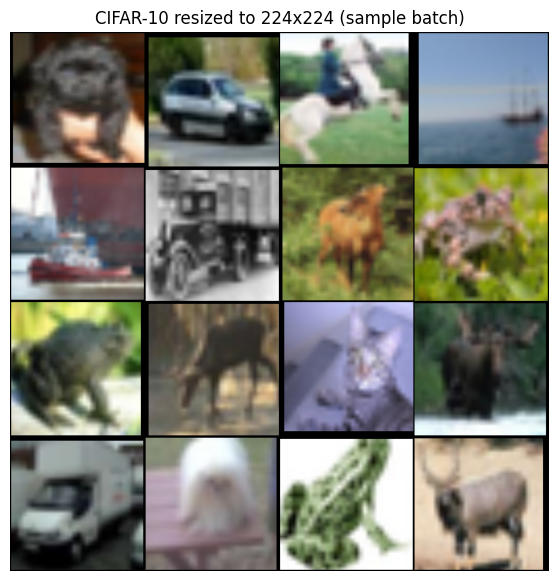

Label examples: ['dog', 'automobile', 'horse', 'ship', 'ship', 'truck', 'deer', 'frog']


In [5]:
images, labels = next(iter(train_loader))
images_vis = denormalize(images[:16]).clamp(0, 1)

fig, ax = plt.subplots(figsize=(7, 7))
grid = torchvision.utils.make_grid(images_vis, nrow=4)
ax.imshow(grid.permute(1, 2, 0))  # CHW -> HWC for matplotlib
ax.set_title("CIFAR-10 resized to 224x224 (sample batch)")
ax.axis("off")
plt.show()

print("Label examples:", [classes[i] for i in labels[:8].tolist()])


## Patchify: turning images into patch tokens

ViT splits an image into non-overlapping $P \times P$ patches.
Each patch is flattened and treated like a token.

For an image with shape $[B, C, H, W]$ and patch size $P$, the number of patches is:

$$
N = \left(\frac{H}{P}\right)\left(\frac{W}{P}\right)
$$

and each patch has dimension $C P^2$.


In [6]:
def patchify(x: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    x: [B, C, H, W]
    returns: [B, N, patch_dim] where patch_dim = C * P * P
    """
    B, C, H, W = x.shape
    P = patch_size
    assert H % P == 0 and W % P == 0, "H and W must be divisible by patch_size"

    # unfold extracts local blocks. With stride == kernel_size, blocks do not overlap.
    patches = x.unfold(2, P, P).unfold(3, P, P)  # [B, C, H/P, W/P, P, P]
    patches = patches.contiguous().view(B, C, -1, P, P)  # [B, C, N, P, P]

    # permute to [B, N, C, P, P] so each patch is grouped together by N
    patches = patches.permute(0, 2, 1, 3, 4)

    # flatten each patch to a vector of length C*P*P
    patches = patches.contiguous().view(B, -1, C * P * P)  # [B, N, patch_dim]
    return patches


## Patchify sanity check

We run patchify on a small batch and print shapes.
For $224 \times 224$ and $P=16$, the number of patches is $N=196$.


In [7]:
x_batch, _ = next(iter(train_loader))
x_batch = x_batch[:2]
patches = patchify(x_batch, patch_size=patch_size)
print("Input:", x_batch.shape)
print("Patches:", patches.shape)  # expected [2, 196, 768] because 3*16*16 = 768


Input: torch.Size([2, 3, 224, 224])
Patches: torch.Size([2, 196, 768])


## Patch embedding, class token, and positional embedding

After patchifying, each patch vector is projected to the model dimension $D$:

$$
\mathbf{z}_i = \mathbf{E}\mathbf{x}_i + \mathbf{b}
$$

ViT prepends a learnable class token and adds learnable positional embeddings:

$$
\mathbf{Z}_0 = [\mathbf{z}_{\mathrm{cls}}; \mathbf{z}_1; \dots; \mathbf{z}_N] + \mathbf{E}_{\mathrm{pos}}
$$

PyTorch layers already include reasonable default initializations, so we do not manually initialize weights here.


In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_chans: int, embed_dim: int):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)

        patch_dim = in_chans * patch_size * patch_size
        self.proj = nn.Linear(patch_dim, embed_dim)  # projects flattened patches to D

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # learnable CLS token
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.num_patches, embed_dim))  # learnable position embedding

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        patches = patchify(x, self.patch_size)  # [B, N, patch_dim]
        tokens = self.proj(patches)             # [B, N, D]

        cls = self.cls_token.expand(B, -1, -1)  # repeats CLS token for each batch item
        tokens = torch.cat([cls, tokens], dim=1)  # [B, 1+N, D]

        tokens = tokens + self.pos_embed  # inject positional information
        return tokens

pe = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=768)

with torch.no_grad():
    tok = pe(x_batch)
print("PatchEmbedding output:", tok.shape)  # expected [2, 197, 768]

print("Initail token values", tok[1][0][:10])
print("Other token values", tok[1][1][:10])

PatchEmbedding output: torch.Size([2, 197, 768])
Initail token values tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Other token values tensor([-0.2095, -1.1364, -0.5504, -0.3538,  1.3066, -0.0338,  0.0293, -0.7473,
         1.3018,  0.2846])


## Attention: the core idea

Self-attention lets each token mix information from all other tokens in the sequence.

Scaled dot-product attention:

$$
\mathrm{Attention}(\mathbf{Q},\mathbf{K},\mathbf{V}) =
\mathrm{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}}\right)\mathbf{V}
$$

The implementation below uses explicit matrix multiplication `q @ k.transpose(-2, -1)`.


In [9]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        d_k = q.shape[-1]

        # k.transpose(-2, -1) turns [B, h, N, d] into [B, h, d, N] so we can do Q @ K^T
        scores = q @ k.transpose(-2, -1)  # [B, h, N, N]
        scores = scores / math.sqrt(d_k)  # scaling keeps scores in a good numeric range

        attn = F.softmax(scores, dim=-1)  # attention weights over keys
        attn = self.dropout(attn)

        out = attn @ v  # weighted sum of values
        return out, attn

attn_layer = ScaledDotProductAttention(dropout=0.0)
q = torch.randn(2, 12, 197, 64)
k = torch.randn(2, 12, 197, 64)
v = torch.randn(2, 12, 197, 64)
with torch.no_grad():
    out, attn = attn_layer(q, k, v)
print("ScaledDotProductAttention out:", out.shape)
print("ScaledDotProductAttention attn:", attn.shape)


ScaledDotProductAttention out: torch.Size([2, 12, 197, 64])
ScaledDotProductAttention attn: torch.Size([2, 12, 197, 197])


## Multi-head self-attention

Multi-head attention runs $h$ attention operations in parallel.
Each head works in a subspace of size $d = D/h$, then heads are concatenated and projected.

The class below returns attention maps for visualization.


In [10]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, attn_dropout: float = 0.0, proj_dropout: float = 0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, 3 * embed_dim)  # one projection for Q, K, V
        self.attn = ScaledDotProductAttention(dropout=attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)     # output projection
        self.proj_dropout = nn.Dropout(proj_dropout)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, N, D = x.shape

        qkv = self.qkv(x)              # [B, N, 3D]
        q, k, v = qkv.chunk(3, dim=-1) # each is [B, N, D]

        q = q.view(B, N, self.num_heads, self.head_dim)
        k = k.view(B, N, self.num_heads, self.head_dim)
        v = v.view(B, N, self.num_heads, self.head_dim)

        # transpose moves the head dimension before sequence length so attention is computed per head
        q = q.transpose(1, 2)  # [B, h, N, d]
        k = k.transpose(1, 2)  # [B, h, N, d]
        v = v.transpose(1, 2)  # [B, h, N, d]

        out, attn = self.attn(q, k, v)

        # merge heads back to D
        out = out.transpose(1, 2).contiguous()  # contiguous makes memory layout compatible with view
        out = out.view(B, N, D)

        out = self.proj(out)
        out = self.proj_dropout(out)
        return out, attn

mhsa = MultiHeadSelfAttention(embed_dim=768, num_heads=12)
x = torch.randn(2, 197, 768)
with torch.no_grad():
    y, a = mhsa(x)
print("MultiHeadSelfAttention out:", y.shape)
print("MultiHeadSelfAttention attn:", a.shape)


MultiHeadSelfAttention out: torch.Size([2, 197, 768])
MultiHeadSelfAttention attn: torch.Size([2, 12, 197, 197])


## MLP inside the encoder

After attention mixes information across tokens, an MLP transforms each token independently:

$$
\mathrm{MLP}(\mathbf{x}) = \mathbf{W}_2 \, \mathrm{GELU}(\mathbf{W}_1 \mathbf{x})
$$

In ViT-Base, hidden size is $4D$.


In [11]:
class MLP(nn.Module):
    def __init__(self, embed_dim: int, mlp_ratio: float = 4.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

mlp = MLP(embed_dim=768, mlp_ratio=4.0, dropout=0.0)
x = torch.randn(2, 197, 768)
with torch.no_grad():
    y = mlp(x)
print("MLP out:", y.shape)


MLP out: torch.Size([2, 197, 768])


## Transformer encoder block

A ViT encoder block uses LayerNorm and residual connections:

$$
\mathbf{y} = \mathbf{x} + \mathrm{MHA}(\mathrm{LN}(\mathbf{x}))
$$

$$
\mathbf{z} = \mathbf{y} + \mathrm{MLP}(\mathrm{LN}(\mathbf{y}))
$$


In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, mlp_ratio: float = 4.0,
                 attn_dropout: float = 0.0, dropout: float = 0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout=attn_dropout, proj_dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio=mlp_ratio, dropout=dropout)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        y, attn = self.attn(self.norm1(x))
        x = x + y
        y = self.mlp(self.norm2(x))
        x = x + y
        return x, attn

blk = EncoderBlock(embed_dim=768, num_heads=12, mlp_ratio=4.0, dropout=0.0)
x = torch.randn(2, 197, 768)
with torch.no_grad():
    y, a = blk(x)
print("EncoderBlock out:", y.shape)
print("EncoderBlock attn:", a.shape)


EncoderBlock out: torch.Size([2, 197, 768])
EncoderBlock attn: torch.Size([2, 12, 197, 197])


## MLP head for classification

The head maps the final $[\mathrm{CLS}]$ token embedding to class logits.
If `representation_size=None`, it is a single linear layer.


In [13]:
class MLPHead(nn.Module):
    def __init__(self, embed_dim: int, num_classes: int, representation_size: Optional[int] = None):
        super().__init__()
        self.representation_size = representation_size

        if representation_size is None:
            self.pre_logits = nn.Identity()
            self.head = nn.Linear(embed_dim, num_classes)
        else:
            self.pre_logits = nn.Linear(embed_dim, representation_size)
            self.act = nn.Tanh()
            self.head = nn.Linear(representation_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pre_logits(x)
        if self.representation_size is not None:
            x = self.act(x)
        x = self.head(x)
        return x

head = MLPHead(embed_dim=768, num_classes=10, representation_size=None)
cls = torch.randn(2, 768)
with torch.no_grad():
    logits = head(cls)
print("MLPHead logits:", logits.shape)


MLPHead logits: torch.Size([2, 10])


## Vision Transformer (ViT-Base/16)

This model uses:
- patch size $16$
- embedding dimension $768$
- 12 encoder blocks
- 12 attention heads
- MLP ratio $4$

The forward pass returns logits with shape $[B, C]$.


In [14]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        num_classes: int = 10,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        attn_dropout: float = 0.0,
        dropout: float = 0.1,
        representation_size: Optional[int] = None,
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.pos_drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            EncoderBlock(embed_dim, num_heads, mlp_ratio, attn_dropout=attn_dropout, dropout=dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = MLPHead(embed_dim, num_classes, representation_size=representation_size)

    def forward(self, x: torch.Tensor, return_attn: bool = False):
        x = self.patch_embed(x)
        x = self.pos_drop(x)

        attn_maps = []
        for blk in self.blocks:
            x, attn = blk(x)
            attn_maps.append(attn)

        x = self.norm(x)
        cls_token = x[:, 0]
        logits = self.head(cls_token)

        if return_attn:
            return logits, attn_maps
        return logits

vit = VisionTransformer(img_size=img_size, patch_size=patch_size, num_classes=10).to(device)
xb, _ = next(iter(train_loader))
with torch.no_grad():
    logits = vit(xb.to(device)[:2])
print("VisionTransformer logits:", logits.shape)


VisionTransformer logits: torch.Size([2, 10])


## Parameter count

We report total parameters and trainable parameters, and also show the count in millions.


In [15]:
def count_parameters(model: nn.Module) -> Tuple[int, int]:
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(vit)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable parameters (millions): {trainable_params/1e6:.2f}M")


Total parameters: 85,806,346
Trainable parameters: 85,806,346
Trainable parameters (millions): 85.81M


## Accuracy function

Accuracy is the fraction of correct predictions computed from logits using $\arg\max$.


In [16]:
def accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


## Training for 2 epochs

Important training operations:
- Forward pass: compute logits from inputs.
- `loss.backward()`: compute gradients for all parameters.
- `optimizer.step()`: update parameters using gradients.
- Scheduler: update learning rate over time.


In [17]:
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, criterion, epoch: int) -> float:
    model.train()
    running_loss = 0.0

    for step, (x, y) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # clears old gradients
        logits = model(x)                      # forward pass
        loss = criterion(logits, y)            # compute loss
        loss.backward()                        # backward pass computes gradients
        optimizer.step()                       # update parameters

        running_loss += loss.item()

        if (step + 1) % 10 == 0:
            print(f"Epoch {epoch} Step {step+1}/{len(loader)} Train Loss {loss.item():.4f}")

    return running_loss / len(loader)


In [18]:
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item()
        total_acc += accuracy(logits, y)

    return total_loss / len(loader), total_acc / len(loader)


## Optimizer, scheduler, and run training

- AdamW updates parameters using adaptive moments and weight decay.
- CosineAnnealingLR changes the learning rate using a cosine schedule across epochs.

We train for 2 epochs and record metrics.


In [19]:
from time import time

model = vit
lr = 3e-4
weight_decay = 0.05
epochs = 2

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

history = {"train_loss": [], "test_loss": [], "test_acc": []}

start = time()
for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} test_loss={test_loss:.4f} test_acc={test_acc*100:.2f}% lr={current_lr:.6f}")

print(f"Done in {(time()-start)/60:.2f} minutes")


Epoch 1 Step 10/313 Train Loss 2.4939
Epoch 1 Step 20/313 Train Loss 2.3264
Epoch 1 Step 30/313 Train Loss 2.2931
Epoch 1 Step 40/313 Train Loss 2.1755
Epoch 1 Step 50/313 Train Loss 2.0952
Epoch 1 Step 60/313 Train Loss 2.1268
Epoch 1 Step 70/313 Train Loss 2.1348
Epoch 1 Step 80/313 Train Loss 2.0631
Epoch 1 Step 90/313 Train Loss 2.1926
Epoch 1 Step 100/313 Train Loss 2.0016
Epoch 1 Step 110/313 Train Loss 1.8113
Epoch 1 Step 120/313 Train Loss 2.0719
Epoch 1 Step 130/313 Train Loss 1.9658
Epoch 1 Step 140/313 Train Loss 2.2262
Epoch 1 Step 150/313 Train Loss 2.0024
Epoch 1 Step 160/313 Train Loss 2.0209
Epoch 1 Step 170/313 Train Loss 1.9808
Epoch 1 Step 180/313 Train Loss 1.8299
Epoch 1 Step 190/313 Train Loss 2.0882
Epoch 1 Step 200/313 Train Loss 2.1508
Epoch 1 Step 210/313 Train Loss 2.0029
Epoch 1 Step 220/313 Train Loss 1.7666
Epoch 1 Step 230/313 Train Loss 1.8597
Epoch 1 Step 240/313 Train Loss 2.1098
Epoch 1 Step 250/313 Train Loss 1.8958
Epoch 1 Step 260/313 Train Loss 1.

## Visualize training curves

Plot loss and accuracy over epochs.


In [20]:
history

{'train_loss': [2.0612044399157883, 1.7941434973725876],
 'test_loss': [1.82599675655365, 1.547288179397583],
 'test_acc': [0.30000001192092896, 0.4000000059604645]}

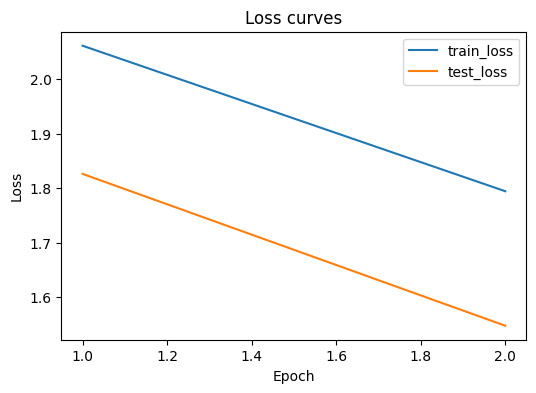

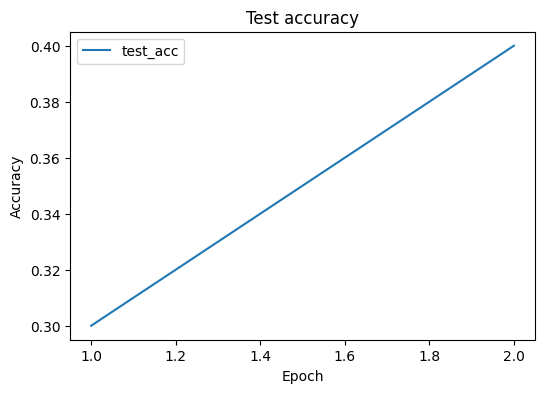

In [21]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(list(epochs_range), history["train_loss"], label="train_loss")
plt.plot(list(epochs_range), history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves")
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(list(epochs_range), history["test_acc"], label="test_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Test accuracy")
plt.show()


## Extract and visualize attention maps

We extract attention matrices from the model and plot one head from one layer.


In [22]:
@torch.no_grad()
def get_attention_maps(model: VisionTransformer, x: torch.Tensor):
    model.eval()
    logits, attn_maps = model(x, return_attn=True)
    return logits, attn_maps


Attention matrix shape: torch.Size([197, 197])


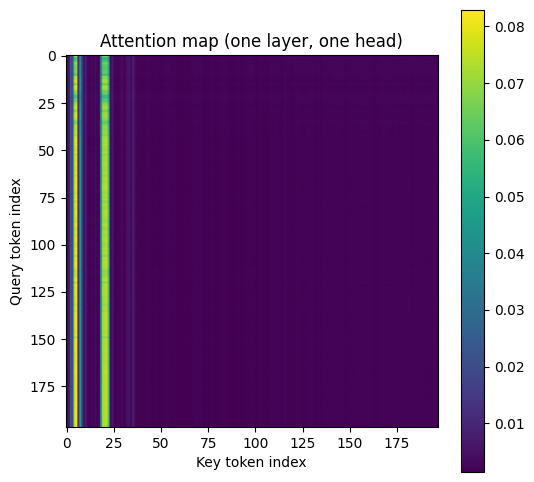

In [23]:
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)[:1]  # take 1 image for attention visualization

logits, attn_maps = get_attention_maps(model, test_images)
last_layer_index = len(attn_maps) - 1
head_index = 0
attention_matrix = attn_maps[last_layer_index][0, head_index]  # [N, N]

print("Attention matrix shape:", attention_matrix.shape)

plt.figure(figsize=(6, 6))
plt.imshow(attention_matrix.detach().cpu().numpy())
plt.title("Attention map (one layer, one head)")
plt.xlabel("Key token index")
plt.ylabel("Query token index")
plt.colorbar()
plt.show()

## Prediction helper and sanity check

We convert logits to predicted labels using $\arg\max$.


In [24]:
@torch.no_grad()
def predict_batch(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    model.eval()
    logits = model(x)
    return logits.argmax(dim=1)


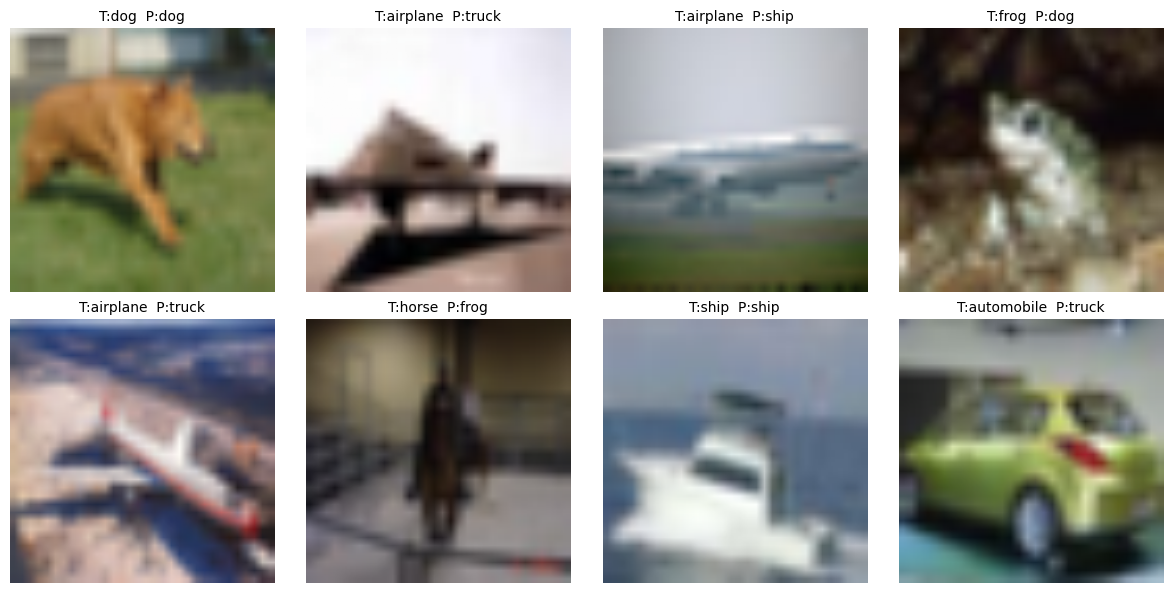

Predictions vs True:
00: pred=       dog  true=       dog
01: pred=     truck  true=  airplane
02: pred=      ship  true=  airplane
03: pred=       dog  true=      frog
04: pred=     truck  true=  airplane
05: pred=      frog  true=     horse
06: pred=      ship  true=      ship
07: pred=     truck  true=automobile


In [25]:
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)[:8]
test_labels_cpu = test_labels[:8]  # keep labels on CPU for indexing class names

predicted_class_ids = predict_batch(model, test_images).cpu()

images_for_plot = denormalize(test_images.cpu()).clamp(0, 1)

# Build per-image titles: "T:<true> P:<pred>"
titles = []
for i in range(len(test_labels_cpu)):
    true_name = classes[test_labels_cpu[i].item()]
    pred_name = classes[predicted_class_ids[i].item()]
    titles.append(f"T:{true_name}  P:{pred_name}")

# Plot in a 2x4 grid with titles above each image
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = images_for_plot[i].permute(1, 2, 0)  # CHW -> HWC
    ax.imshow(img)
    ax.set_title(titles[i], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

print("Predictions vs True:")
for i in range(8):
    print(f"{i:02d}: pred={classes[predicted_class_ids[i].item()]:>10s}  true={classes[test_labels_cpu[i].item()]:>10s}")


